<a href="https://colab.research.google.com/github/W-Bernau/QiskitAlgorithms/blob/main/Qiskit_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

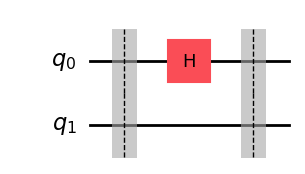

In [92]:
#Importing Libraries
from qiskit import *
from qiskit_aer import Aer
from math import pi, gcd
import numpy as np
from qiskit.visualization import plot_bloch_multivector,plot_state_qsphere
import matplotlib.pyplot as plt

#Drawing a Basic Circuit
qc = QuantumCircuit(2)
qc.barrier()
qc1 = qc.copy()
qc.h(0)
qc.barrier()
qc2 =qc.copy()
qc.draw('mpl')

In [63]:
#Showing two different states
backend = Aer.get_backend('statevector_simulator')
q1 = transpile(qc1,backend)
job1 = (backend.run(q1)).result().get_statevector()

backend = Aer.get_backend('statevector_simulator')
q2 = transpile(qc2,backend)
job2 = (backend.run(q2)).result().get_statevector()

print(job1,job2)

Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2)) Statevector([0.70710678+0.j, 0.70710678+0.j, 0.        +0.j,
             0.        +0.j],
            dims=(2, 2))


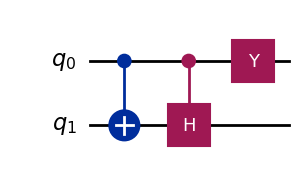

In [64]:
#Showing the Pauli & Hardaman Gate (controlled NOT)
q = QuantumRegister(2)
qc = QuantumCircuit(2)
qc.cx(0,1)
qc.ch(0,1)
qc.y(0)
qc.draw(output='mpl')

In [51]:
backend = Aer.get_backend('unitary_simulator')
job = transpile(qc, backend)
result = (backend.run(job)).result()
print(result.get_unitary(qc, decimals=3))

Operator([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


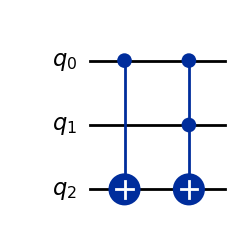

In [57]:
#Showing an elementary three qubit gates
q = QuantumRegister(3)
qc = QuantumCircuit(3)
qc.cx(0,2)
qc.ccx(0,1,2)
qc.draw(output='mpl')

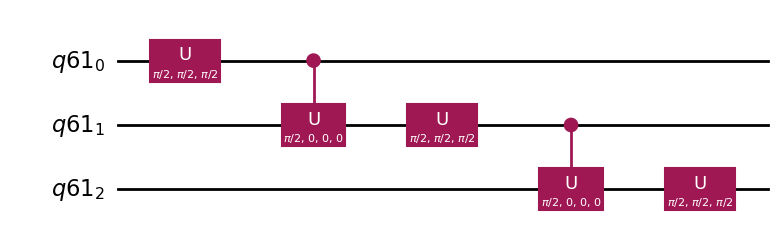

In [79]:
#Showing U Operator and Phase Gates
q = QuantumRegister(3)
qc = QuantumCircuit(q)

qc.u(pi/2,pi/2,pi/2,q[0])
qc.cu(pi/2, 0, 0, 0, 0, 1)
qc.u(pi/2,pi/2,pi/2,q[1])
qc.cu(pi/2, 0, 0, 0, 1, 2)
qc.u(pi/2,pi/2,pi/2,q[2])

qc.draw(output='mpl')

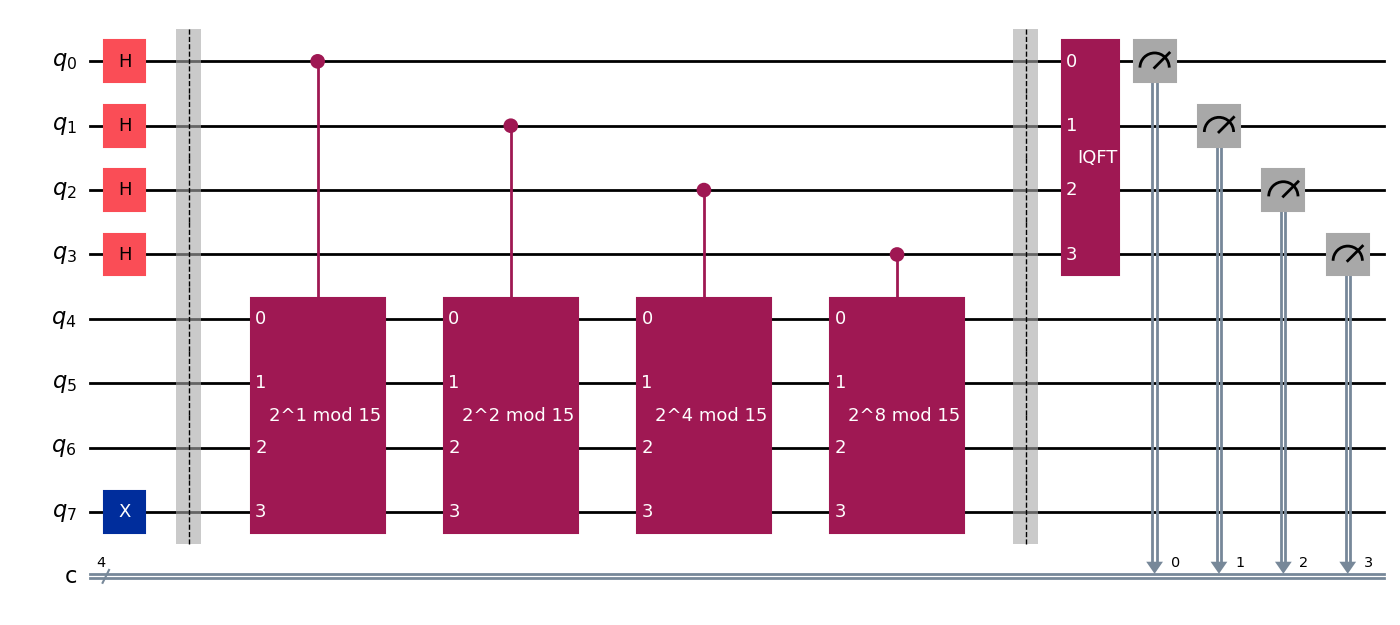

In [113]:
from qiskit.circuit.library import QFT
from fractions import Fraction

def modular_exponentiation(given_circuit, n, m, a):
    for x in range(n):
        exponent = 2**x
        given_circuit.append(a_x_mod15(a, exponent),
                     [x] + list(range(n, n+m)))

def shor_circuit(a,n,m):
    # Input : a - guess for factor of 15
    #         n - number of measurements
    #         m - number of target qubits

    # Setting up circuit
    shor = QuantumCircuit(n+m, n)

    # Initializing firsts n qubits with Hadamard
    shor.h(range(n))
    # Applying sigma_x gate to last qubit
    shor.x(n+m-1)
    shor.barrier()

    #Apply modular exponentiation gates
    modular_exponentiation(shor, n, m, a)
    shor.barrier()

    #Apply inverse QFT
    shor.append(QFT(n, do_swaps=False).inverse(), range(n))

    # measure the first n qubits
    shor.measure(range(n), range(n))

    return shor

n = 4; m = 4; a = 2
shor_example = shor_circuit(a,n,m)
shor_example.draw(output = 'mpl')




In [112]:
#Shor's Algorithm for 15
backend = Aer.get_backend('qasm_simulator')
def factor(N=15,backend=backend):
    found_factors = False
    n = len(bin(N))-2
    m = n
    valid_a = [2,7,8,11,13]
    while found_factors == False:
        # STEP 1: Choose a randomly in valid a's
        if len(valid_a)==0:
            break
        a = np.random.choice(valid_a)
        print(f"Trying a = {a}")

        r = 1 #defining a wrong r

        # STEP 2: Find period r
        while a**r%N != 1: #Adding loop because QPE + continued fractions can find wrong r
            ## Substep 2.1: Find phase s/r
            #Defining Shor's Circuits (QPE):
            qc = shor_circuit(a,n,m)
            #Doing the measurement (binary):
            measure = (transpile(qc, backend=backend))
            job = (backend.run(measure, shots=1,memory=True)).result().get_memory()[0]
            #Converting to decimal base:
            job = int(job,2)
            phase = job/(2**(n-1))
            ## Substep 2.2: Find denominator r (Continued fraction algorithm)
            r = Fraction(phase).limit_denominator(N).denominator

        # STEPS 3 and 4: check if r is even and a^(r/2) != -1 (mod N)
        if r%2==0 and (a**(r/2)+1)%N!=0:
            #STEP 5: Compute factors
            factors = [gcd(a**(r//2)-1,N),gcd(a**(r//2)+1,N)]
            print(f" --- order r = {r}")
            if factors[0] not in [1,N]: # Check to see if factor is a non trivial one
                found_factors = True
                print(f" --- Sucessfully found factors {factors}")
            else:
                print(f" --- Trivial factors found: [1,15]")
        if found_factors == False:
            print(f" --- a={a} failed!")
        valid_a.remove(a)
factor()

Trying a = 8
 --- order r = 8
 --- Trivial factors found: [1,15]
 --- a=8 failed!
Trying a = 7
 --- order r = 8
 --- Trivial factors found: [1,15]
 --- a=7 failed!
Trying a = 11
 --- order r = 8
 --- Trivial factors found: [1,15]
 --- a=11 failed!
Trying a = 13
 --- order r = 8
 --- Trivial factors found: [1,15]
 --- a=13 failed!
Trying a = 2
 --- order r = 8
 --- Trivial factors found: [1,15]
 --- a=2 failed!
